# Direct Column Breakthrough simulation

This example shows how to set up and run a direct column breakthrough (DCB) simulation
as described in [Haghpanah et al. 2013](http://dx.doi.org/10.1021/ie302658y).
This simulation inolves injection of a two component flue gas (CO2 and N2)
into a column of Zeolite 13X initially filled with N2.

Adsorption onto Zeolite 13X is modelled with a dual-site Langumuir adsorption isotherm.
Injection flow rate is fixed at the right hand side of the column and the left hand side of the column
is open.
There is no heat transfer between the column and the column wall.

First we load the necessary modules

In [1]:
import Jutul
import JutulDarcy
import Mocca

Then we define parameters which we want. We have defined a structure containing
parameters from Haghpanah et al. 2013 which we load now.
As we are doing a DCB simulation we will set the heat transfer coefficient between
the column and the wall and the wall and the outside to zero.

In [2]:
constants = Mocca.HaghpanahConstants{Float64}(h_in=0.0,h_out=0.0);

# Define the model
Next we need to make the model. This model contains information about
the domain (grid) over which we will solve the equations and information
about the system of equations which we are solving.

Because JutulDarcy has its roots in reservoir simulation we formulate
our velocity equation in the following form:

$$
v = -\frac{k}{\mu}(\nabla P)
$$

where `k` is known as the permeability.
In this instance we use the pressure drop equation for plug flow in a packed
bed:

$$
v=-\frac{4}{150}\frac{\epsilon^3}{(1-\epsilon)^2} r_{i n}^2 \frac{1}{\mu}(\nabla P)
$$

The permeability of the system is then given by:

$$
k = \frac{4}{150}\frac{\epsilon^3}{(1-\epsilon)^2} r_{i n}^2
$$
We calculate the permability and dispersion which are used to specify the model

In [3]:
permeability = Mocca.compute_permeability(constants);
axial_dispersion = Mocca.calc_dispersion(constants);

We set up a two component adsorption system. This system type is associated
with the appropriate equations and primary and secondary variables.

In [4]:
system = Mocca.TwoComponentAdsorptionSystem(; permeability = permeability, dispersion = axial_dispersion, p = constants);

Jutul uses finite volume discretisation in space. To model a 1D cylindrical column
we setup a cartesian grid with dimensions ncells x 1 x 1.
To ensure we have the correct interface area between cells we set each dimension
to the square root of the inner column area. We can then define the simulation domain.

In [5]:
ncells = 200;
dx = sqrt(pi*constants.r_in^2);
mesh = Jutul.CartesianMesh((ncells, 1, 1), (constants.L, dx, dx));
domain = Mocca.mocca_domain(mesh, system);

The domain also contains the mass diffusion coefficient to calculate mass
transport between cells and the thermal conductivity to calculate heat
transfer.

# Create the model
Now we can assemble the model which contains the domain and the system of equations.

In [6]:
model = Jutul.SimulationModel(domain, system, general_ad = true);

# Setup the initial state

The final thing required to create the simulator is the intial state of the
system.

In [7]:
bar = Jutul.si_unit(:bar);
P_init = 1*bar;
T_init = 298.15;
Tw_init = constants.T_a;

To avoid numerical errors we set the initial CO2 concentration to be very
small instead of 0.

In [8]:
yCO2 = fill(1e-10, ncells)
y_init = hcat(yCO2, 1 .- yCO2);

Now we can initialise the state in the column

In [9]:
state0, prm = Mocca.initialise_state_AdsorptionColumn(P_init, T_init, Tw_init, y_init, model);

# Setup the timestepping and boundary conditions

For the DCB we are only running the adsorption stage of a VSA process.
We will use a total time of 5000 seconds with a single report step

In [10]:
t_ads = 5000;
maxdt = 5000.0;
numsteps = Int(floor(t_ads / maxdt));
timesteps = fill(maxdt, numsteps);

We set up boundary conditions for an adsorption stage. AdsorptionBC sets a fixed
velocity, concentration and temperature at the inlet, and fixed pressure at
the outlet. By convention we assume the inlet bc is applied on the left hand
side and the outlet bc is applied on the right hand side.

In [11]:
bc = Mocca.AdsorptionBC(y_feed = constants.y_feed, PH = constants.p_high, v_feed = constants.v_feed,
                                T_feed = constants.T_feed, cell_left = 1, cell_right = ncells);

sim_forces = Jutul.setup_forces(model, bc=bc);

# Simulate

Set up timesteppers based on target changes with an initial timestep of 1 day

In [12]:
t_c = Jutul.VariableChangeTimestepSelector(:y, 0.01, relative = false)
t_t = Jutul.VariableChangeTimestepSelector(:Temperature, 10.0, relative = false)
t_p = Jutul.VariableChangeTimestepSelector(:Pressure, 10.0, relative = false);
t_base = Jutul.TimestepSelector(initial_absolute = 1.0)
timesteppers = [t_base, t_c, t_t, t_p];

We define the simulation setup with initial states and parameters, a linear solver
and other configurable options

In [13]:
sim = Jutul.Simulator(model; state0 = state0, parameters = prm)

lsolve = Jutul.LUSolver()

cfg = Jutul.simulator_config(sim;
    timestep_selectors = timesteppers,
    output_substates = true,
    linear_solver = lsolve,
    info_level = 0
);

For more verbose simulation output
info_level can be set to a number higher than 0.

Now we are ready to run the simulation.

In [14]:
result = Jutul.simulate!(sim, timesteps;
    config = cfg,
    forces = sim_forces,
);

Jutul: Simulating 1 hour, 23.33 minutes as 1 report steps
╭────────────────┬──────────┬───────────────┬──────────╮
│ Iteration type │ Avg/step │  Avg/ministep │    Total │
│                │  1 steps │ 302 ministeps │ (wasted) │
├────────────────┼──────────┼───────────────┼──────────┤
│ Newton         │    614.0 │       2.03311 │  614 (0) │
│ Linearization  │    916.0 │       3.03311 │  916 (0) │
│ Linear solver  │    614.0 │       2.03311 │  614 (0) │
│ Precond apply  │      0.0 │           0.0 │    0 (0) │
╰────────────────┴──────────┴───────────────┴──────────╯
╭───────────────┬──────────┬────────────┬──────────╮
│ Timing type   │     Each │   Relative │    Total │
│               │       μs │ Percentage │       ms │
├───────────────┼──────────┼────────────┼──────────┤
│ Properties    │  20.4380 │     2.20 % │  12.5489 │
│ Equations     │ 224.5590 │    36.06 % │ 205.6961 │
│ Assembly      │  11.7414 │     1.89 % │  10.7552 │
│ Linear solve  │ 514.0848 │    55.34 % │ 315.6480 │
│ Lin

# Plot
Get the substates and subtimesteps used inside the simulator for visualisation

In [15]:
substates, subtimesteps = Jutul.expand_to_ministeps(result);

We plot primary variables at the outlet through time

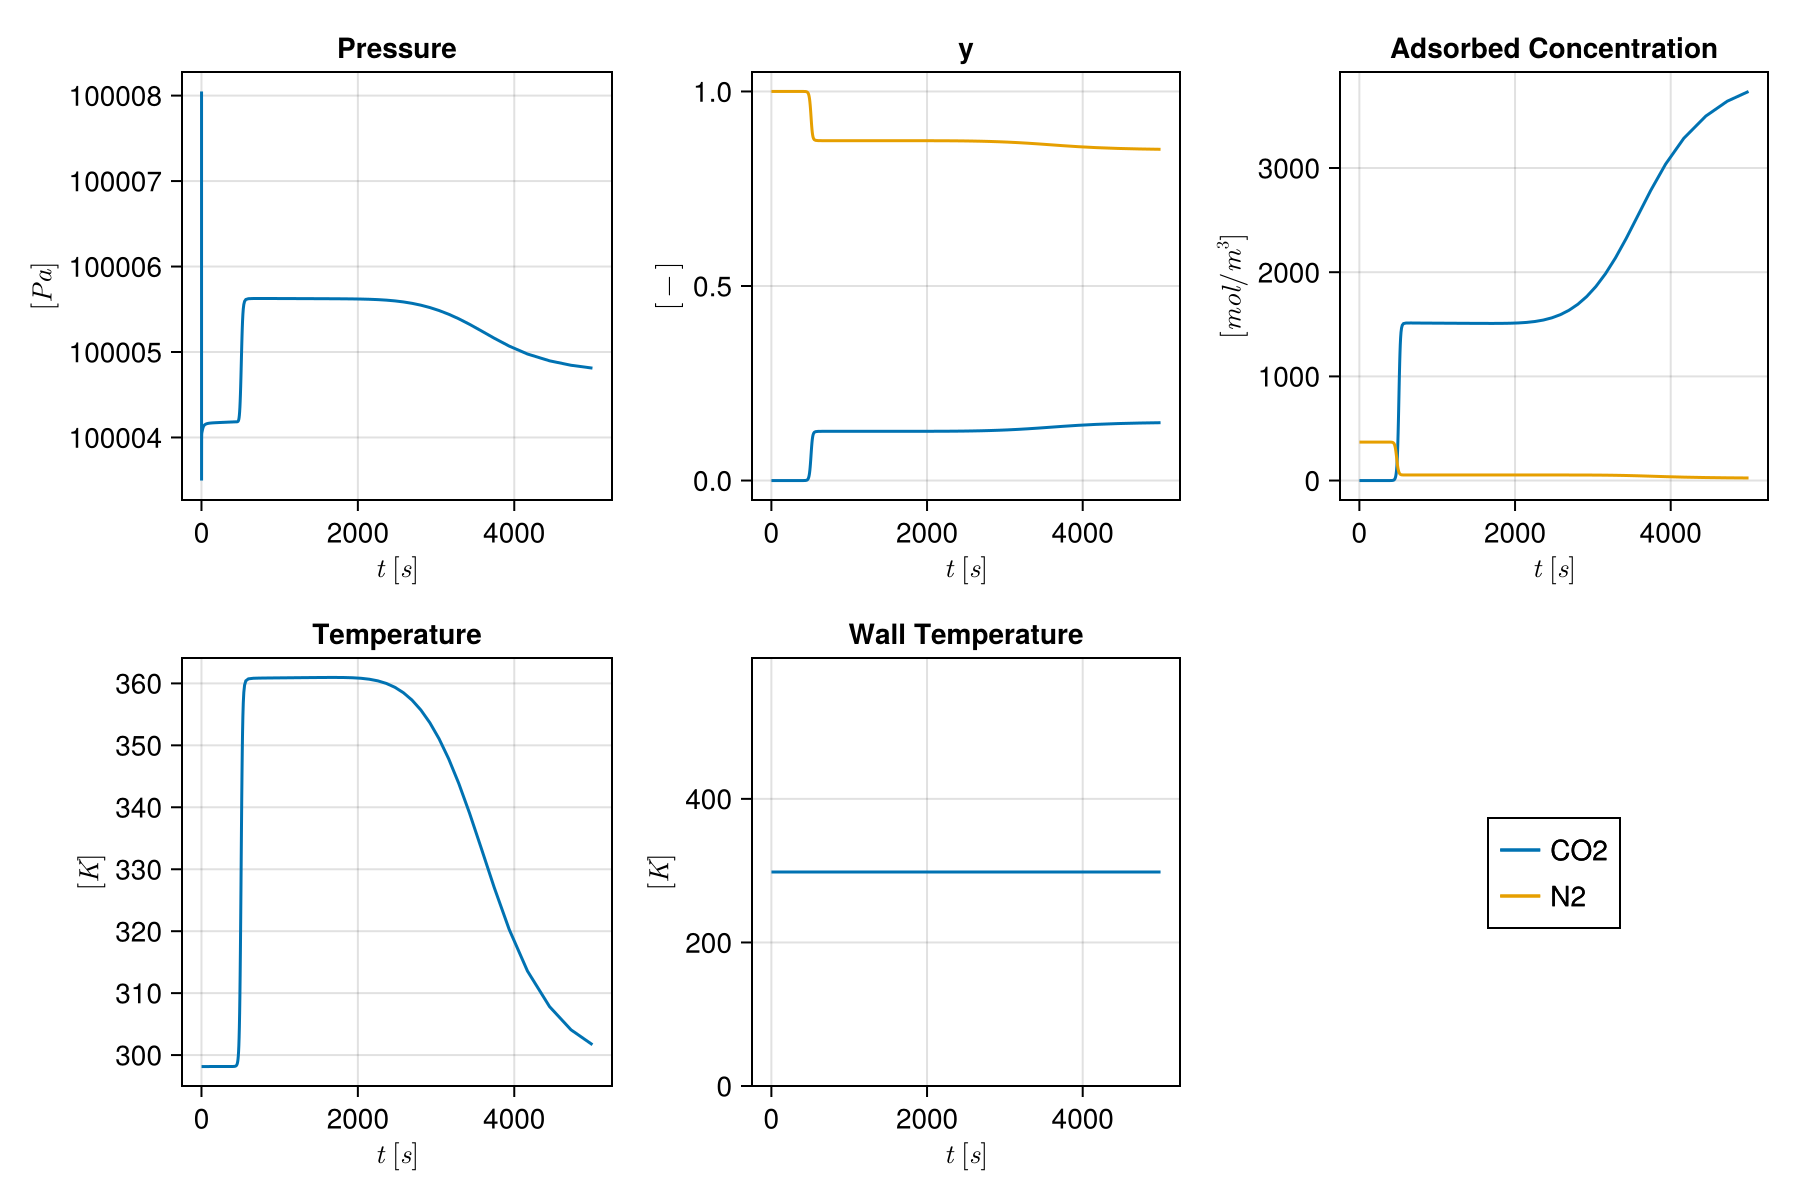

In [16]:
outlet_cell = ncells
f_outlet = Mocca.plot_cell(substates, model, subtimesteps, outlet_cell)

We also plot primary variables along the column at the end of the simulation

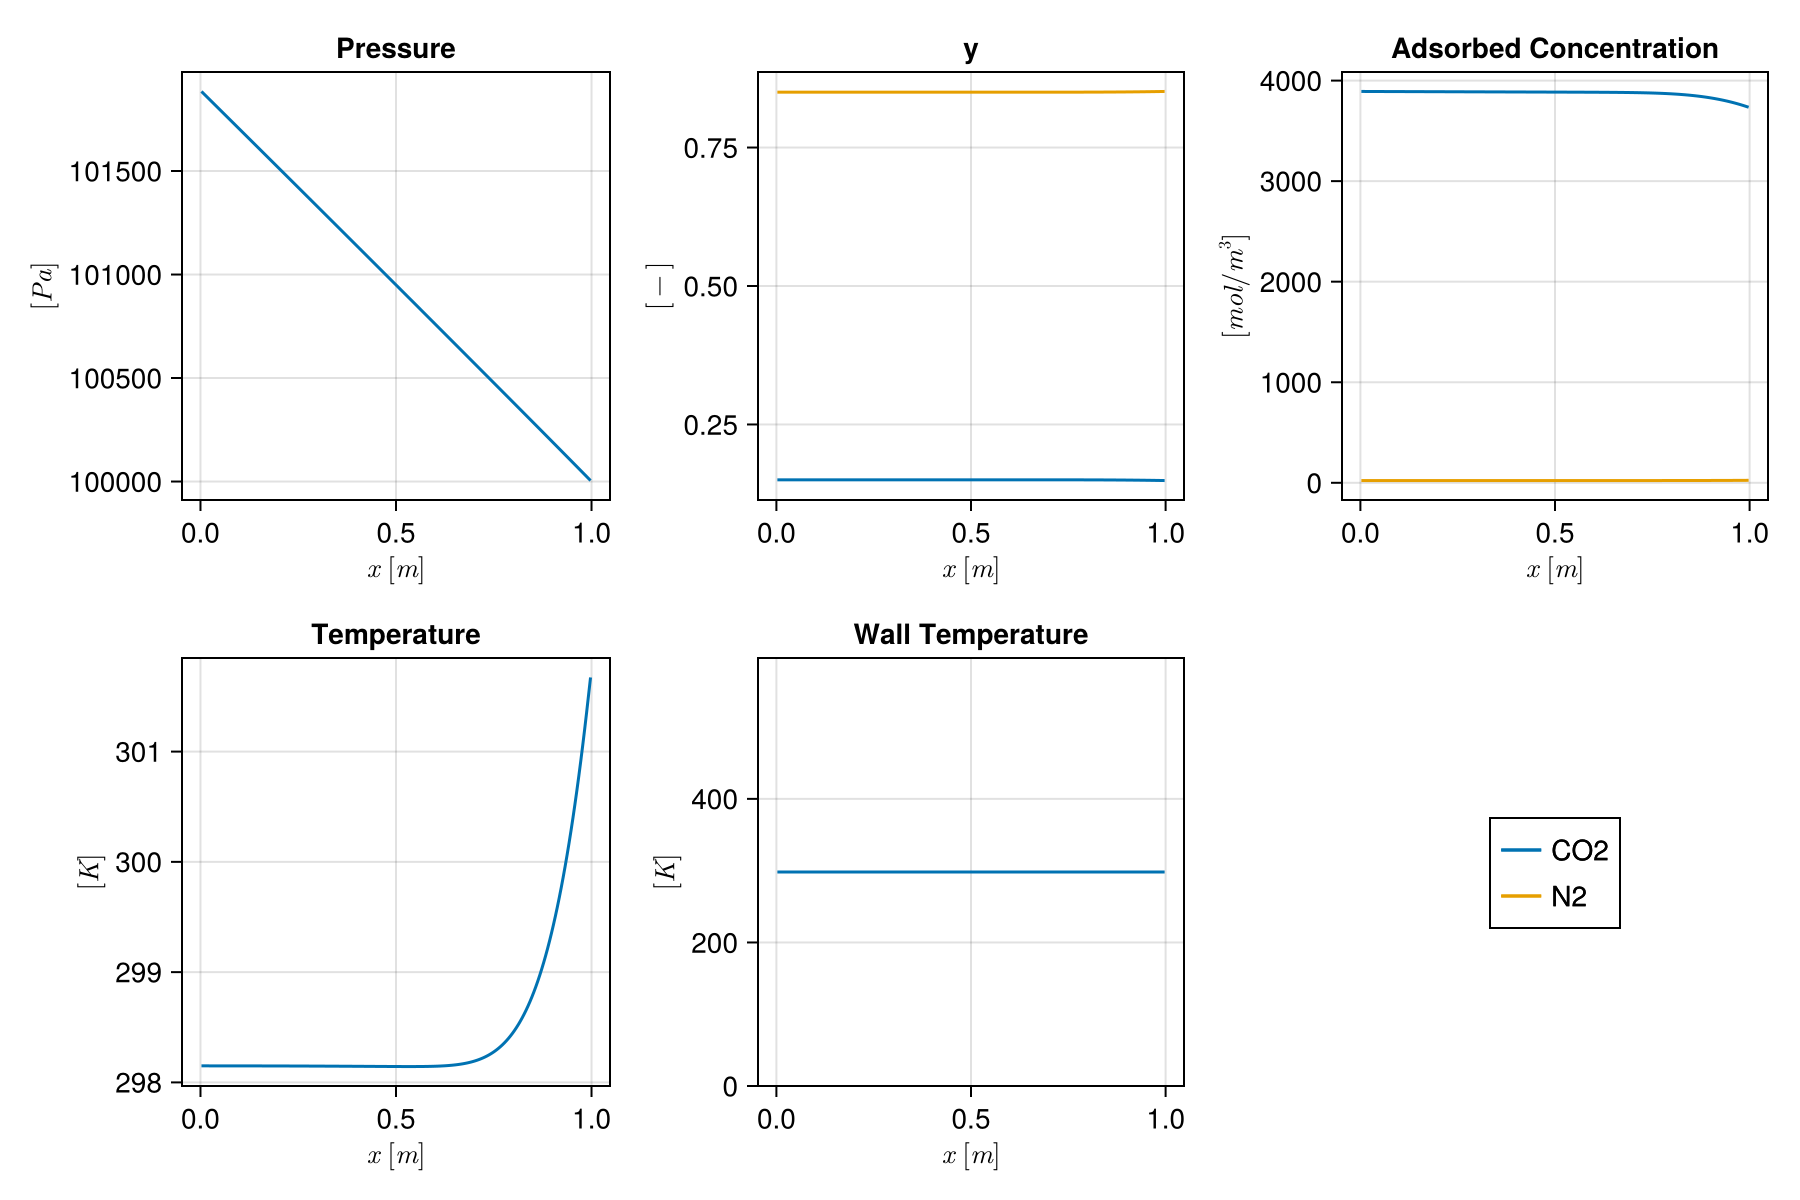

In [17]:
f_column = Mocca.plot_state(substates[end], model)

## Example on GitHub
If you would like to run this example yourself, it can be downloaded from [the Mocca.jl GitHub repository](https://github.com/sintefmath/Mocca.jl/blob/main/examples/simulate_DCB.jl).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*